In [82]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import MinMaxScaler

import umap
import hdbscan

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Выберем топовые признаки из обучения в добавок к эмбеддингам

In [8]:
top_features = [
    #'developer',
    'hours',
    'wday',
    'month',
    'city',
    'gamecategory',
    'minutes'
]

In [9]:
train = pd.read_csv('../data/main.csv', usecols=['bundle', 'os'] + top_features)

train = train[train['os'] == 'android'].reset_index(drop=True)

train = train.sample(50_000, random_state=42)

train.drop(columns=['os'], inplace=True)

print(train.shape)
train.head()

(50000, 7)


,gamecategory,bundle,city,wday,month,minutes,hours
25206952,Games,com.smallgiantgames.empires,Краснодар,5,9,47,6
2347384,Games,com.mars.avgchapters,Москва,1,8,35,14
20238933,Games,com.fugo.wow,Ставрополь,5,8,29,11
29495207,Games,com.ftkg.wordtower,Новосибирск,0,8,7,13
30066808,Games,com.belkatechnologies.clockmaker,Тавда,0,8,53,14


In [10]:
train.to_csv('../data/train_sample_pro.csv', index=False)

In [74]:
#train = pd.read_csv('../data/train_sample_pro.csv')

In [73]:
google_features = pd.read_csv('../data/parsed_final.csv', usecols=['appId', 'description', 'developer', 'title'])

google_features.rename(columns={'appId': 'bundle'}, inplace=True)

print(google_features.shape)
google_features.head()

(59369, 4)


,bundle,title,description,developer
0,com.MadOut.BIG,MadOut2 BigCityOnline,Number one mobile game with open world! Online...,MadOut Games
1,com.easybrain.solitaire.klondike.free,Solitaire Klondike,Solitaire is a time-tested classic card game e...,Easybrain
2,com.orbitalknight.ridiculousfreekick,Crazy Kick!,"Get to the goal!Overtake your opponents, move ...",VOODOO
3,com.FidgetTrading3D.game,Fidget Trading 3D - Fidget Toys,Want to collect ALL The Fidgets In The World? ...,MagicLab
4,com.hwg.sos,Brain Wash - Thinking Game,"How often do you talk to your brain? Hey, frie...",SayGames Ltd


In [15]:
vectorizer = TfidfVectorizer(max_features=128)

description_embeddings = vectorizer.fit_transform(google_features['description'].fillna('nan').unique().tolist())

description_embeddings_df = pd.DataFrame(description_embeddings.toarray(), columns=['tfidf_' + f for f in vectorizer.get_feature_names()])

In [75]:
google_features = google_features.join(description_embeddings_df)

google_features.drop(columns=['description'], inplace=True)

In [76]:
train = train.merge(google_features, on='bundle', how='left')

# заполним пропуски
train.fillna(0, inplace=True)

print(train.shape)
train.head()

(50000, 137)


,gamecategory,bundle,city,wday,month,minutes,hours,title,developer,tfidf_2021,tfidf_3d,tfidf_adventure,tfidf_all,tfidf_also,tfidf_amazing,tfidf_an,tfidf_and,tfidf_android,tfidf_any,tfidf_app,tfidf_application,tfidf_are,tfidf_as,tfidf_at,tfidf_battle,tfidf_be,tfidf_beautiful,tfidf_become,tfidf_best,tfidf_but,tfidf_by,tfidf_can,tfidf_car,tfidf_choose,tfidf_city,tfidf_com,tfidf_create,tfidf_different,tfidf_do,tfidf_download,tfidf_drive,tfidf_driving,tfidf_each,tfidf_easy,tfidf_enjoy,tfidf_experience,tfidf_features,tfidf_find,tfidf_for,tfidf_free,tfidf_friends,tfidf_from,tfidf_fun,tfidf_game,tfidf_games,tfidf_get,tfidf_has,tfidf_have,tfidf_help,tfidf_high,tfidf_how,tfidf_if,tfidf_in,tfidf_into,tfidf_is,tfidf_it,tfidf_just,tfidf_level,tfidf_levels,tfidf_like,tfidf_love,tfidf_make,tfidf_many,tfidf_mode,tfidf_more,tfidf_most,tfidf_music,tfidf_need,tfidf_new,tfidf_no,tfidf_not,tfidf_now,tfidf_of,tfidf_offline,tfidf_on,tfidf_one,tfidf_only,tfidf_or,tfidf_other,tfidf_our,tfidf_out,tfidf_own,tfidf_phone,tfidf_photo,tfidf_play,tfidf_police,tfidf_puzzle,tfidf_racing,tfidf_real,tfidf_realistic,tfidf_robot,tfidf_screen,tfidf_shooting,tfidf_simple,tfidf_simulator,tfidf_skills,tfidf_so,tfidf_start,tfidf_take,tfidf_that,tfidf_the,tfidf_their,tfidf_them,tfidf_there,tfidf_this,tfidf_time,tfidf_to,tfidf_truck,tfidf_try,tfidf_unique,tfidf_up,tfidf_us,tfidf_use,tfidf_very,tfidf_video,tfidf_wallpaper,tfidf_wallpapers,tfidf_want,tfidf_way,tfidf_we,tfidf_when,tfidf_which,tfidf_will,tfidf_with,tfidf_world,tfidf_you,tfidf_your
0,Games,com.smallgiantgames.empires,Краснодар,5,9,47,6,Empires & Puzzles: Match-3 RPG,Small Giant Games,0.000000,0.0,0.248586,0.062548,0.000000,0.107223,0.151575,0.478254,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.135104,0.000000,0.000000,0.106604,0.0,0.000000,0.071901,0.058123,0.0,0.000000,0.000000,0.000000,0.000000,0.089261,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.102243,0.071194,0.000000,0.000000,0.000000,0.062359,0.172516,0.000000,0.000000,0.000000,0.099080,0.0,0.000000,0.000000,0.197566,0.0,0.100122,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.076054,0.000000,0.0000,0.089953,0.235721,0.000000,0.120188,0.000000,0.000000,0.000000,0.089525,0.000000,0.00000,0.000000,0.0,0.0,0.071610,0.0,0.136264,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.108211,0.209173,0.070494,0.043927,0.0,0.000000,0.000000,0.000000,0.000000,0.132802,0.0,0.000000,0.109882,0.187771,0.100782,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.249535,0.091626,0.046220,0.437073
1,Games,com.mars.avgchapters,Москва,1,8,35,14,Chapters: Interactive Stories,Crazy Maple Studio Dev,0.000000,0.0,0.044499,0.067180,0.000000,0.000000,0.081400,0.249053,0.0,0.000000,0.000000,0.0,0.043891,0.075361,0.000000,0.000000,0.024394,0.000000,0.038166,0.0,0.000000,0.077226,0.062427,0.0,0.343671,0.045405,0.111377,0.041311,0.031957,0.000000,0.033001,0.04954,0.0,0.039261,0.0,0.000000,0.0,0.024660,0.000000,0.018302,0.000000,0.000000,0.172025,0.095412,0.066977,0.061764,0.082369,0.000000,0.074368,0.000000,0.0,0.000000,0.000000,0.159147,0.0,0.107537,0.0,0.034962,0.000000,0.000000,0.0,0.125834,0.119783,0.000000,0.0,0.026364,0.0,0.0,0.00000,0.081686,0.000000,0.0000,0.032205,0.202542,0.000000,0.064544,0.029977,0.038097,0.068831,0.000000,0.134326,0.00000,0.118739,0.0,0.0,0.051275,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.03184,0.077483,0.037444,0.151428,0.393162,0.0,0.000000,0.000000,0.040777,0.000000,0.348667,0.0,0.038967,0.078680,0.000000,0.036082,0.000000,0.0,0.0,0.0,0.0,0.000000,0.037283,0.0,0.037824,0.0,0.067791,0.142941,0.000000,0.248216,0.365120
2,Games,com.fugo.wow,Ставрополь,5,8,29,11,Words of Wonders: Crossword to Connect Vocabulary,Fugo Games,0.000000,0.0,0.035485,0.053572,0.079195,0.030612,0.021637,0.248253,0.0,0.025198,0.000000,0.0,0.052500,0.060095,0.100214,0.000000,0.097262,0.032363,0.030435,0.0,0.054934,0.082109,0.016594,0.0,0.000000,0.03620

# Преобразуем категориальные признаки

In [41]:
train['developer'].nunique()

2730

In [42]:
train['city'].nunique()

1111

In [43]:
train['gamecategory'].nunique()

4

In [77]:
developer_sparse = pd.get_dummies(train['developer'])

city_sparse = pd.get_dummies(train['city'])

gamecategory_sparse = pd.get_dummies(train['gamecategory'])

wday_sparse = pd.get_dummies(train['wday'])

month_sparse = pd.get_dummies(train['month'])

In [78]:
train = train.join(developer_sparse.drop(columns=[0]))
train = train.join(city_sparse.drop(columns=[0]))
train = train.join(gamecategory_sparse.drop(columns=[0]))
train = train.join(wday_sparse.drop(columns=[0]))
train = train.join(month_sparse)

train.drop(columns=['developer', 'city', 'gamecategory', 'wday', 'month'], inplace=True)

print(train.shape)
train.head()

(50000, 3983)


bundle  minutes  hours  \
0       com.smallgiantgames.empires       47      6   
1              com.mars.avgchapters       35     14   
2                      com.fugo.wow       29     11   
3                com.ftkg.wordtower        7     13   
4  com.belkatechnologies.clockmaker       53     14   

                                               title  tfidf_2021  tfidf_3d  \
0                     Empires & Puzzles: Match-3 RPG    0.000000       0.0   
1                      Chapters: Interactive Stories    0.000000       0.0   
2  Words of Wonders: Crossword to Connect Vocabulary    0.000000       0.0   
3                          Word Tower: Connect Words    0.000000       0.0   
4                         Clockmaker: Match 3 Games!    0.047997       0.0   

   tfidf_adventure  tfidf_all  tfidf_also  tfidf_amazing  tfidf_an  tfidf_and  \
0         0.248586   0.062548    0.000000       0.107223  0.151575   0.478254   
1         0.044499   0.067180    0.000000       0.000000  0.081400   0.249053   
2         0.035485   0.053572    0.079195       0.030612  0.021637   0.248253   
3         0.000000   0.000000    0.000000       0.000000  0.000000   0.000000   
4         0.162094   0.020393    0.000000       0.069917  0.000000   0.269327   

   tfidf_android  tfidf_any  tfidf_app  tfidf_application  tfidf_are  \
0            0.0   0.000000   0.000000                0.0   0.000000   
1            0.0   0.000000   0.000000                0.0   0.043891   
2            0.0   0.025198   0.000000                0.0   0.052500   
3            0.0   0.000000   0.000000                0.0   0.000000   
4            0.0   0.028775   0.027174                0.0   0.019985   

   tfidf_as  tfidf_at  tfidf_battle  tfidf_be  tfidf_beautiful  tfidf_become  \
0  0.000000  0.000000      0.135104  0.000000         0.000000      0.106604   
1  0.075361  0.000000      0.000000  0.024394         0.000000      0.038166   
2  0.060095  0.100214      0.000000  0.097262         0.032363      0.030435   
3  0.000000  0.000000      0.000000  0.000000         0.000000      0.000000   
4  0.000000  0.000000      0.000000  0.022214         0.036958      0.000000   

   tfidf_best  tfidf_but  tfidf_by  tfidf_can  tfidf_car  tfidf_choose  \
0         0.0   0.000000  0.071901   0.058123        0.0      0.000000   
1         0.0   0.000000  0.077226   0.062427        0.0      0.343671   
2         0.0   0.054934  0.082109   0.016594        0.0      0.000000   
3         0.0   0.000000  0.000000   0.000000        0.0      0.000000   
4         0.0   0.062734  0.000000   0.018950        0.0      0.000000   

   tfidf_city  tfidf_com  tfidf_create  tfidf_different  tfidf_do  \
0    0.000000   0.000000      0.000000         0.089261  0.000000   
1    0.045405   0.111377      0.041311         0.031957  0.000000   
2    0.036207   0.000000      0.065886         0.050967  0.027191   
3    0.000000   0.000000      0.000000         0.000000  0.000000   
4    0.041348   0.169044      0.000000         0.029102  0.000000   

   tfidf_download  tfidf_drive  tfidf_driving  tfidf_each  tfidf_easy  \
0        0.000000      0.00000            0.0    0.000000         0.0   
1        0.033001      0.04954            0.0    0.039261         0.0   
2        0.000000      0.00000            0.0    0.093924         0.0   
3        0.000000      0.00000            0.0    0.000000         0.0   
4        0.030052      0.00000            0.0    0.000000         0.0   

   tfidf_enjoy  tfidf_experience  tfidf_features  tfidf_find  tfidf_for  \
0     0.000000               0.0        0.000000    0.000000   0.102243   
1     0.000000               0.0        0.024660    0.000000   0.018302   
2     0.049637               0.0        0.000000    0.111115   0.000000   
3     0.000000               0.0        0.000000    0.000000   0.000000   
4     0.113370               0.0        0.022457    0.000000   0.116671   

   tfidf_free  tfidf_friends  tfidf_from  tfidf_fun  tfidf_game  tfidf_games  

In [83]:
scaler = MinMaxScaler()

t = scaler.fit_transform(train.drop(columns=['bundle', 'title']))

In [84]:
pd.DataFrame(t)

0         1         2         3         4         5         6     \
0      0.796610  0.260870  0.000000  0.000000  0.294352  0.098711  0.000000   
1      0.593220  0.608696  0.000000  0.000000  0.052692  0.106021  0.000000   
2      0.491525  0.478261  0.000000  0.000000  0.042018  0.084545  0.176198   
3      0.118644  0.565217  0.000000  0.000000  0.000000  0.000000  0.000000   
4      0.898305  0.608696  0.047997  0.000000  0.191936  0.032183  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
49995  0.254237  0.173913  0.000000  0.091661  0.000000  0.000000  0.000000   
49996  0.711864  0.956522  0.000000  0.040083  0.000000  0.036030  0.000000   
49997  0.525424  0.173913  0.000000  0.000000  0.333656  0.000000  0.000000   
49998  0.355932  0.565217  0.000000  0.000000  0.000000  0.039877  0.083107   
49999  0.762712  0.565217  0.000000  0.000000  0.000000  0.018829  0.156966   

           7         8         9         10        11        12    13    \
0      0.197115  0.384785  0.478254  0.000000  0.000000  0.000000   0.0   
1      0.000000  0.206640  0.249053  0.000000  0.000000  0.000000   0.0   
2      0.056275  0.054927  0.248253  0.000000  0.056915  0.000000   0.0   
3      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   0.0   
4      0.128532  0.000000  0.269327  0.000000  0.064997  0.035715   0.0   
...         ...       ...       ...       ...       ...       ...   ...   
49995  0.000000  0.000000  0.290321  0.000000  0.000000  0.000000   0.0   
49996  0.000000  0.000000  0.333259  0.000000  0.072766  0.039984   0.0   
49997  0.000000  0.087233  0.394265  0.000000  0.000000  0.000000   0.0   
49998  0.000000  0.000000  0.386405  0.000000  0.161070  0.088506   0.0   
49999  0.000000  0.036699  0.124400  0.023613  0.000000  0.020895   0.0   

           14        15        16        17        18        19        20    \
0      0.000000  0.000000  0.000000  0.176890  0.000000  0.000000  0.115129   
1      0.093319  0.075361  0.000000  0.000000  0.054207  0.000000  0.041218   
2      0.111624  0.060095  0.218115  0.000000  0.216130  0.044649  0.032869   
3      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4      0.042491  0.000000  0.000000  0.000000  0.049364  0.050988  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
49995  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.192193   
49996  0.190280  0.000000  0.000000  0.129131  0.055264  0.000000  0.000000   
49997  0.059092  0.031813  0.000000  0.721834  0.068650  0.000000  0.052201   
49998  0.315894  0.085034  0.000000  0.000000  0.000000  0.063178  0.000000   
49999  0.024860  0.107071  0.072865  0.000000  0.057762  0.000000  0.021961   

           21        22        23        24    25        26        27    \
0      0.000000  0.000000  0.089343  0.113630   0.0  0.000000  0.000000   
1      0.000000  0.000000  0.095960  0.122045   0.0  0.669323  0.051448   
2      0.000000  0.111171  0.102028  0.032441   0.0  0.000000  0.041026   
3      0.000000  0.000000  0.000000  0.000000   0.0  0.000000  0.000000   
4      0.000000  0.126957  0.000000  0.037047   0.0  0.000000  0.046852   
...         ...       ...       ...       ...   ...       ...       ...   
49995  0.000000  0.000000  0.074574  0.000000   0.0  0.000000  0.719678   
49996  0.057217  0.000000  0.032611  0.082951   0.0  0.075820  0.000000   
49997  0.000000  0.000000  0.000000  0.000000   0.0  0.000000  0.000000   
49998  0.000000  0.078654  0.000000  0.229518   0.0  0.083915  0.058052   
49999  0.000000  0.037139  0.000000  0.108374   0.0  0.000000  0.000000   

           28        29        30        31        32        33    34    \
0      0.000000  0.000000  0.145174  0.000000  0.000000  0.000000   0.0   
1      0.111377  0.062293  0.051975  0.000000  0.042324  0.059127   0.0   
2      0.000000  0.099349  0.082893  0.035730  0.000000  0.000000   0.0   
3      0.00

In [91]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=128, 
                            metric='cosine').fit_transform(train.drop(columns=['bundle', 'title', 'minutes', 'hours']))

In [92]:
umap_embeddings = pd.DataFrame(umap_embeddings)

In [93]:
cluster = hdbscan.HDBSCAN(min_cluster_size=150, metric='euclidean').fit(umap_embeddings.fillna(0)) # cluster_selection_method='eom'

In [94]:
print('Уникальных кластеров:', len(set(cluster.labels_)))

Уникальных кластеров: 19


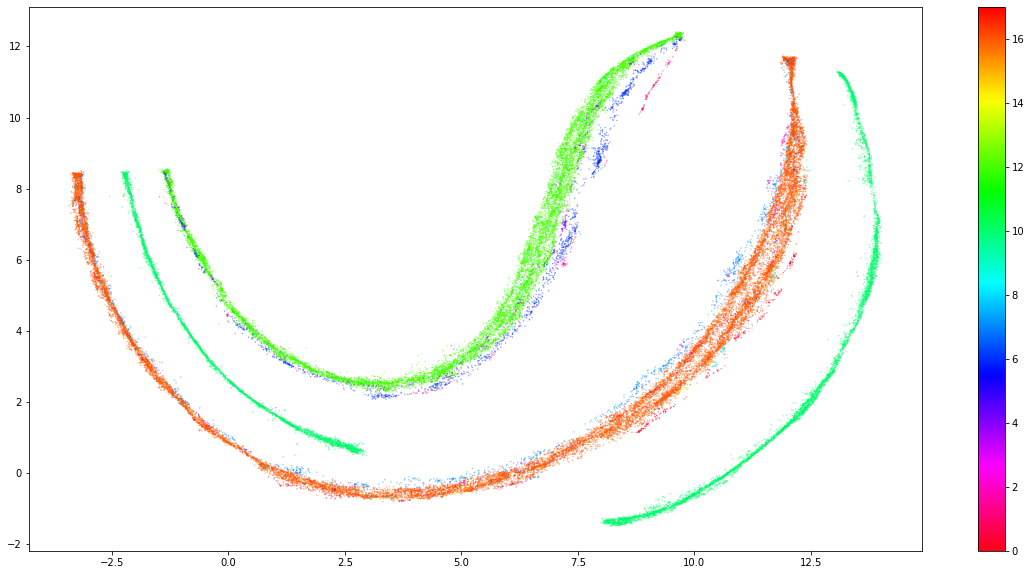

In [95]:
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(train.drop(columns=['bundle', 'title']))
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()
plt.show()

# Сохраним файлы для Tensorflow Projector

In [81]:
# Tensorflow Projector поддерживает максимум 10 тысяч точек, поэтому выгрузим именно столько
pd.DataFrame(t).sample(10_000, random_state=42).to_csv('../data/sample_tf_pr_pro.tsv', index=False, sep='\t', header=None)
train[['title']].sample(10_000, random_state=42).to_csv('../data/sample_tf_pr_labels_pro.tsv', index=False, sep='\t', header=None)